In [9]:
import gzip
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import shutil

# Example of directly accessing S3 from notebook (did not scale well for extracting files)

In [3]:
# Example for opening a bucket as a filesystem and viewing the contents
if False:
    import s3fs # for attaching S3 bucket to notebook
    fs = s3fs.S3FileSystem(anon=False, key='<key>', secret='<secret>')
    fs.ls('s3://bucket/path/')

In [4]:
# Example code for loading data from S3 into the notebook
if False:
    bucket='my-bucket'
    data_key = 'train.csv'
    data_location = 's3://{}/{}'.format(bucket, data_key)
    pd.read_csv(data_location)

In [5]:
# Example for opening a file for read
if False:
    img_file = fs.open('s3://descriptiveworld-datasets/DeepFashion1/Img/img.zip', 'rb')

# Copy files from S3 bucket to notebook EC2 instance

In [57]:
# run only the first time the instance is created and launched
#!mkdir ../../../DeepFashion1
#!cd ../../../DeepFashion1

In [ ]:
# setup aws CLI with personal credentials
# this command may be easier to run from a terminal session instead of notebook
#!aws configure

In [ ]:
# copy the DF1 bucket from S3 to this instance
#!aws s3 cp s3://descriptiveworld-datasets/DeepFashion1/ . --recursive

In [10]:
!ls ../../../DeepFashion1

Anno_coarse  Anno_fine	Eval  Img  README.txt  temp


# Inspect full image archive without extracting all files

In [11]:
pre_path = '../../../DeepFashion1/'

In [12]:
zipf = zipfile.ZipFile(pre_path+'Img/img.zip') # not using high-res images to simplify data wrangling

In [13]:
filenames = zipf.namelist()
df = pd.DataFrame([x.split('/') for x in filenames[:]], columns=['root_path', 'product_name', 'filename'])
df['path'] = filenames

In [14]:
df = df.dropna()
df = df[df.filename != '']
df = df.reset_index()
print(len(df))
df.sample(n=10)

289229


,index,root_path,product_name,filename,path
2457,2517,img,Abstract_Geo-Embroidered_Shorts,img_00000005.jpg,img/Abstract_Geo-Embroidered_Shorts/img_000000...
248562,253451,img,Striped_Linen_Ringer_Tee,img_00000017.jpg,img/Striped_Linen_Ringer_Tee/img_00000017.jpg
38403,39136,img,Cable_Knit_Fringe_Cardigan,img_00000023.jpg,img/Cable_Knit_Fringe_Cardigan/img_00000023.jpg
55920,56956,img,Classic_Wash_Overall_Shorts,img_00000006.jpg,img/Classic_Wash_Overall_Shorts/img_00000006.jpg
183864,187438,img,Mixed_Media_Knit_Tee,img_00000012.jpg,img/Mixed_Media_Knit_Tee/img_00000012.jpg
122379,124649,img,Floral_Lace_Overlay_Dress,img_00000033.jpg,img/Floral_Lace_Overlay_Dress/img_00000033.jpg
72245,73605,img,Crochet_Cover-Up_Tank,img_00000043.jpg,img/Crochet_Cover-Up_Tank/img_00000043.jpg
84785,86375,img,Denim_Utility_Romper,img_00000019.jpg,img/Denim_Utility_Romper/img_00000019.jpg
123020,125299,img,Floral_Lace_Skater_Skirt,img_00000033.jpg,img/Floral_Lace_Skater_Skirt/img_00000033.jpg
118155,120355,img,Floral_A-Line_Midi_Skirt,img_00000054.jpg,img/Floral_A-Line_Midi_Skirt/img_00000054.jpg


In [15]:
osize = 0 
for item in zipf.infolist():
    osize += item.file_size
print('uncompressed size =',round(osize/1000000000,2),'GB')

uncompressed size = 2.74 GB


# Basic EDA

### Number of product types (each image file is a unique product)

In [16]:
# Number of unique products
products = np.unique(df.product_name)
len(products)

5621

In [17]:
def flattenTypes(val):
    lst = val.split('_')
    return lst[-1]

In [18]:
df['product_type'] = df.product_name.apply(flattenTypes)
all_cats = np.unique(df.product_type)
print(len(all_cats))
all_cats

46


array(['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Caftan',
       'Capris', 'Cardigan', 'Chinos', 'Coat', 'Coverup', 'Culottes',
       'Cutoffs', 'Dress', 'Flannel', 'Gauchos', 'Halter', 'Henley',
       'Hoodie', 'Jacket', 'Jeans', 'Jeggings', 'Jersey', 'Jodhpurs',
       'Joggers', 'Jumpsuit', 'Kaftan', 'Kimono', 'Leggings', 'Onesie',
       'Parka', 'Peacoat', 'Poncho', 'Robe', 'Romper', 'Sarong', 'Shorts',
       'Skirt', 'Sweater', 'Sweatpants', 'Sweatshorts', 'Tank', 'Tee',
       'Top', 'Trunks', 'Turtleneck'], dtype=object)

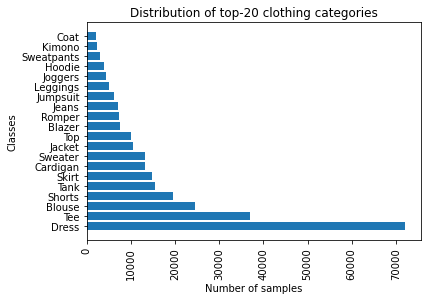

In [19]:
histdata = df.groupby(['product_type']).count()
histdata = histdata.sort_values(by='root_path', ascending=False)

data = histdata['root_path'][:20]
plt.barh(data.index, data.values)
plt.title('Distribution of top-20 clothing categories')
plt.xticks(rotation = 90)
plt.ylabel('Classes')
plt.xlabel('Number of samples')
plt.show()

In [56]:
histdata[histdata['root_path'] > 1000]

,index,root_path,product_name,filename,path
product_type,,,,,
Dress,72158,72158,72158,72158,72158
Tee,36887,36887,36887,36887,36887
Blouse,24562,24562,24562,24562,24562
Shorts,19666,19666,19666,19666,19666
Tank,15429,15429,15429,15429,15429
Skirt,14773,14773,14773,14773,14773
Cardigan,13311,13311,13311,13311,13311
Sweater,13123,13123,13123,13123,13123
Jacket,10467,10467,10467,10467,10467


### Load the bounding box data and merge with the file list

In [26]:
# read in the bounding box dataset for all records
f = open(pre_path+'/Anno_coarse/list_bbox.txt', 'rt')
boxes = f.readlines()
boxes = boxes[2:]
boxes = [x.replace('\n', '') for x in boxes]
#boxes = [x.replace('img/', 'img_highres/') for x in boxes]
boxes = [' '.join(x.split()).split() for x in boxes]
df_boxes = pd.DataFrame(boxes, columns=['path', 'x1', 'y1', 'x2', 'y2'])
df_boxes.head()

,path,x1,y1,x2,y2
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,072,079,232,273
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,067,059,155,161
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,065,065,156,200
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,051,062,167,182
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,046,088,166,262


In [27]:
df_all = df.merge(df_boxes, on='path')
df_all.sample(5)

,index,root_path,product_name,filename,path,product_type,x1,y1,x2,y2
190117,193818,img,Open-Front_Collarless_Blazer,img_00000013.jpg,img/Open-Front_Collarless_Blazer/img_00000013.jpg,Blazer,102,043,176,149
59930,61045,img,Colorblock_Athletic_Tank,img_00000033.jpg,img/Colorblock_Athletic_Tank/img_00000033.jpg,Tank,008,001,178,300
22839,23283,img,Belted_Utility_Romper,img_00000031.jpg,img/Belted_Utility_Romper/img_00000031.jpg,Romper,056,049,181,276
91844,93572,img,Dotted_Chiffon_Blouse,img_00000008.jpg,img/Dotted_Chiffon_Blouse/img_00000008.jpg,Blouse,001,038,210,246
105291,107273,img,Epic_Weekend_Muscle_Tee,img_00000013.jpg,img/Epic_Weekend_Muscle_Tee/img_00000013.jpg,Tee,028,038,172,244


### Inspect a few sample images and corresponding bounding boxes

In [28]:
toplot = df_all[df_all.product_name=='Scalloped_Halter_Dress'][:10]

In [30]:
# extract sample images from archive to disk
filelist = toplot.path.values
zipf.extractall(path=pre_path+'temp/', members=filelist)

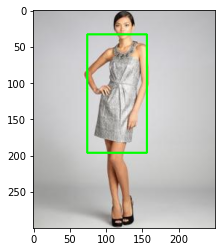

In [31]:
row = toplot.iloc[8].values
img = cv2.imread(pre_path+'temp/'+row[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(x1, y1, x2, y2) = [int(x) for x in row[-4:]]
img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

# Prepare subset of overall data based on specific categories of products

### Sample files in categories

In [32]:
cats = ['Tee', 'Blouse', 'Shorts', 'Jeans']
subset = df_all[df_all.product_type.isin(cats)]

In [33]:
# numitems is used to determine the category with the smallest number of items
numitems = min(subset.groupby('product_type').count().path)

In [34]:
# then we sample numitems * 70% in each of the cateogries to leave images for later validation and/or testing
subsample = subset.groupby('product_type').sample(n=int(numitems*.7))
len(subsample)

19812

In [35]:
# Extract all the sample files from the zipped archive to disk
filelist = subsample.path.values
zipf.extractall(path=pre_path+'fashion/', members=filelist)

### Determine dimensions and remove samples not meeting criteria

In [36]:
# determine the dimensions of each image
# this is necessary for YOLOv5 training, where we have to specify a "longest" dimension for the training
dims = []
for file in filelist[:]:
    i = Image.open(pre_path+'fashion/'+file)
    dims.append([*i.size])
dims_df = pd.DataFrame(dims, columns=['i_w', 'i_h'])

In [37]:
most_common_w = dims_df.groupby('i_w').count().sort_values(by='i_h', ascending=False).iloc[:1]
most_common_h = dims_df.groupby('i_h').count().sort_values(by='i_w', ascending=False).iloc[:1]
print(most_common_w)
print(most_common_h)

      i_h
i_w      
300  5939
       i_w
i_h       
300  14434


In [38]:
most_common_dim = 300

In [39]:
subsample = pd.concat([subsample.reset_index(drop=True), dims_df.reset_index(drop=True)], axis=1)

In [40]:
# determine which images are outside the range of the 
toobig = subsample[(subsample['i_w'] > most_common_dim) | (subsample['i_h'] > most_common_dim)]
toosmall = subsample[(subsample['i_w'] < most_common_dim) & (subsample['i_h'] < most_common_dim)]
print(len(toobig), len(toosmall))

1290 2584


In [41]:
toobig.groupby('product_type').count()['path'] + toosmall.groupby('product_type').count()['path']

product_type
Blouse    1052
Jeans      784
Shorts    1016
Tee       1022
Name: path, dtype: int64

In [42]:
subsample = subsample[~subsample.path.isin(toobig.path)]
subsample = subsample[~subsample.path.isin(toosmall.path)]
subsample.head()

,index,root_path,product_name,filename,path,product_type,x1,y1,x2,y2,i_w,i_h
0,72036,img,Crochet-Trimmed_Blouse,img_00000065.jpg,img/Crochet-Trimmed_Blouse/img_00000065.jpg,Blouse,090,088,229,250,300,300
2,242538,img,Split-Back_Pleated_Blouse,img_00000028.jpg,img/Split-Back_Pleated_Blouse/img_00000028.jpg,Blouse,006,024,198,300,200,300
3,118811,img,Flat_Collar_Woven_Blouse,img_00000007.jpg,img/Flat_Collar_Woven_Blouse/img_00000007.jpg,Blouse,040,060,135,300,205,300
4,191987,img,Off-The-Shoulder_Blouse,img_00000155.jpg,img/Off-The-Shoulder_Blouse/img_00000155.jpg,Blouse,170,116,295,237,300,270
5,240757,img,Southwestern_Print_Blouse,img_00000020.jpg,img/Southwestern_Print_Blouse/img_00000020.jpg,Blouse,029,061,267,228,300,300


In [43]:
# is it still balanced across classes?
subsample.groupby('product_type').count()['path']

product_type
Blouse    3901
Jeans     4169
Shorts    3937
Tee       3931
Name: path, dtype: int64

In [44]:
# remove images from disk that are not within required size (300px on one or more dimensions)
for file in toobig.path.values:
    os.remove(pre_path+'fashion/'+file)
    
for file in toosmall.path.values:
    os.remove(pre_path+'fashion/'+file)

### Prepare additional fields for YOLOv5 label data format

In [45]:
# calculate the elements needed for the YOLOv5 PyTorch training input labels/
subsample.x1 = subsample.x1.astype(int)
subsample.y1 = subsample.y1.astype(int)
subsample.x2 = subsample.x2.astype(int)
subsample.y2 = subsample.y2.astype(int)
subsample.i_w = subsample.i_w.astype(int)
subsample.i_h = subsample.i_h.astype(int)

subsample['x'] = subsample.apply(lambda row: (((row.x2 - row.x1)/2) + row.x1) / row.i_w, axis=1)
subsample['y'] = subsample.apply(lambda row: (((row.y2 - row.y1)/2) + row.y1) / row.i_h, axis=1)
subsample['w'] = subsample.apply(lambda row: (row.x2 - row.x1) / row.i_w, axis=1)
subsample['h'] = subsample.apply(lambda row: (row.y2 - row.y1) / row.i_h, axis=1)
subsample.head()

,index,root_path,product_name,filename,path,product_type,x1,y1,x2,y2,i_w,i_h,x,y,w,h
0,72036,img,Crochet-Trimmed_Blouse,img_00000065.jpg,img/Crochet-Trimmed_Blouse/img_00000065.jpg,Blouse,90,88,229,250,300,300,0.531667,0.563333,0.463333,0.540000
2,242538,img,Split-Back_Pleated_Blouse,img_00000028.jpg,img/Split-Back_Pleated_Blouse/img_00000028.jpg,Blouse,6,24,198,300,200,300,0.510000,0.540000,0.960000,0.920000
3,118811,img,Flat_Collar_Woven_Blouse,img_00000007.jpg,img/Flat_Collar_Woven_Blouse/img_00000007.jpg,Blouse,40,60,135,300,205,300,0.426829,0.600000,0.463415,0.800000
4,191987,img,Off-The-Shoulder_Blouse,img_00000155.jpg,img/Off-The-Shoulder_Blouse/img_00000155.jpg,Blouse,170,116,295,237,300,270,0.775000,0.653704,0.416667,0.448148
5,240757,img,Southwestern_Print_Blouse,img_00000020.jpg,img/Southwestern_Print_Blouse/img_00000020.jpg,Blouse,29,61,267,228,300,300,0.493333,0.481667,0.793333,0.556667


### Verify reconstruction of bboxes

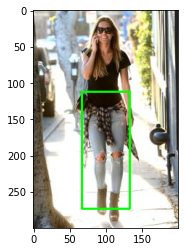

In [46]:
# visually inspect some manually chosen random items
row = subsample.iloc[5000].values
img = cv2.imread(pre_path+'fashion/'+row[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
(i_w, i_h, x, y, w, h) = row[-6:]
# reconstruct the bboxes
x1 = int((x-w/2)*i_w)
y1 = int((y-h/2)*i_h)
x2 = int((x+w/2)*i_w)
y2 = int((y+h/2)*i_h)
img_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

### Create label/*.txt and data.yaml files

In [47]:
# create 1 label file for each image
for i, entry in subsample.iterrows():
    # see YOLOv5 pytorch data format:  class x_center y_center width height
    idx = cats.index(entry.product_type)
    metadata = str(idx)+' ' + ' '.join([str(round(x,3)) for x in entry.iloc[-4:]])    
    filepath = entry.path.split('.')[0]
    fileroot = pre_path+'fashion/labels/'+filepath
    
    if not os.path.exists(os.path.dirname(fileroot)):
        try:
            os.makedirs(os.path.dirname(fileroot))
        except: # Guard against race condition
            print(problem)
            raise
    
    f = open(fileroot+'.txt', 'w')
    f.write(metadata)
    f.close()

In [48]:
lines = []
lines.append('path: ../datasets/fashion # root dir\n')
lines.append('train: images/train\n')
lines.append('val: images/val\n')
lines.append('test:  # test images (optional)\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open(pre_path+'fashion/fashion.yaml', 'w')
f.writelines(lines)
f.close()

# Split into Train/Val

In [49]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(subsample, test_size=0.2)

In [50]:
if not os.path.exists(pre_path+'fashion/images'):
    os.mkdir(pre_path+'fashion/images')
if not os.path.exists(pre_path+'fashion/images/train'):
    os.mkdir(pre_path+'fashion/images/train')
if not os.path.exists(pre_path+'fashion/images/val'):
    os.mkdir(pre_path+'fashion/images/val')

if not os.path.exists(pre_path+'fashion/labels'):
    os.mkdir(pre_path+'fashion/labels')
if not os.path.exists(pre_path+'fashion/labels/train'):
    os.mkdir(pre_path+'fashion/labels/train')
if not os.path.exists(pre_path+'fashion/labels/val'):
    os.mkdir(pre_path+'fashion/labels/val')

In [51]:
for i, file in val.iterrows():
    base=file.path
    src = pre_path+'fashion/'+base
    dest = pre_path+'fashion/images/val/'+base.replace('img/', '')
    folder = pre_path+'fashion/images/val/' + '/'.join(base.split('/')[1:-1])
    if not os.path.exists(folder):
        os.mkdir(folder)
    try:
        shutil.move(src, dest)
    except:
        print('error on ',src)

    lbl_base = base.split('.')[0]+'.txt'
    lbl_src = pre_path+'fashion/labels/'+lbl_base
    lbl_dest = pre_path+'fashion/labels/val/'+lbl_base.replace('img/', '')
    folder = pre_path+'fashion/labels/val/' + '/'.join(base.split('/')[1:-1])
    if not os.path.exists(folder):
        os.mkdir(folder)
    try:
        shutil.move(lbl_src, lbl_dest)
    except:
        print('error on ',src)

error on  ../../../DeepFashion1/fashion/img/L.A.T.H.C._Graphic_Drawstring_Shorts/img_00000005.jpg
error on  ../../../DeepFashion1/fashion/img/L.A.T.H.C._Graphic_Drawstring_Shorts/img_00000031.jpg
error on  ../../../DeepFashion1/fashion/img/L.A._Graphic_Tee/img_00000035.jpg
error on  ../../../DeepFashion1/fashion/img/L.A.T.H.C._Graphic_Drawstring_Shorts/img_00000027.jpg
error on  ../../../DeepFashion1/fashion/img/L.A._Graphic_Tee/img_00000059.jpg
error on  ../../../DeepFashion1/fashion/img/L.A.T.H.C._Abstract_Print_Tee/img_00000008.jpg
error on  ../../../DeepFashion1/fashion/img/L.A._Graphic_Tee/img_00000023.jpg


# Cleanup remaining paths and create .zip for YOLOv5 training

In [53]:
!mv ../../../DeepFashion1/fashion/img/* ../../../DeepFashion1/fashion/images/train
!rm -r ../../../DeepFashion1/fashion/img

In [54]:
!mv ../../../DeepFashion1/fashion/labels/img/* ../../../DeepFashion1/fashion/labels/train
!rm -r ../../../DeepFashion1/fashion/labels/img

In [55]:
!zip -r -q ../../../DeepFashion1/fashion.zip ../../../DeepFashion1/fashion

# Next

- Load the zip file to the yolov5/pytorch training environment in path datasets/ (to create).
- Unzip the file
- Copy or move the .yaml file to the path yolov5/data/ (expected by train.py from yolov5).  This path is available after running the setup notebook cell which clones the yolov5 repo.